# Monthly Modeling
-------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from sklearn import metrics
from sklearn.model_selection import train_test_split

from pmdarima.arima import auto_arima

from fbprophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation,rmse, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot


plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../capstone-data/monthly-merged.csv')

In [3]:
df

,date,bus,rail_boardings,total_rides,prcp,tmax,tmin,gas_open,gas_close,gas_volume,3_mo,6_mo,1_yr,2_yr,3_yr,5_yr,7_yr,10_yr,20_yr,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyLegacyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,total_daily_doses,total_daily_cum,first_dose_daily,first_dose_cum,first_dose_percent_pop,vax_series_completed_daily,vax_series_cum,vax_series_percent,crash_occurrences,damage_indicator,gas_price,new_light_truck_reg,new_car_reg,new_total_reg
0,2001-01-01,23041470.0,13493968.0,36535438.0,0.031429,30.828571,18.885714,0.844743,0.850791,15564.657143,5.403429,5.238571,4.881714,4.788857,4.788286,4.838857,5.102857,5.113143,5.616571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.52400,NaN,NaN,NaN
1,2001-02-01,23759284.0,13668317.0,37427601.0,0.120357,36.285714,21.392857,0.868661,0.872911,16613.464286,5.018571,4.902857,4.697857,4.675000,4.726071,4.896786,5.111429,5.120000,5.631429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.48225,NaN,NaN,NaN
2,2001-03-01,24168043.0,14003603.0,38171646.0,0.054643,41.892857,26.571429,0.882089,0.883479,16562.321429,4.604286,4.510357,4.333929,4.361429,4.436786,4.643214,4.880000,4.872857,5.471786,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.38750,NaN,NaN,NaN
3,2001-04-01,29703959.0,17392629.0,47096588.0,0.097429,63.028571,42.714286,1.016229,1.020600,22347.628571,4.010857,4.006571,4.010286,4.242857,4.424000,4.753714,5.020000,5.117429,5.754286,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.69380,NaN,NaN,NaN
4,2001-05-01,23772416.0,13938165.0,37710581.0,0.131071,72.714286,53.678571,1.068571,1.070586,21264.178571,3.703214,3.749643,3.795357,4.267857,4.513571,4.931429,5.240000,5.390000,5.922500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.98250,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2021-08-01,12359912.0,9379462.0,21739374.0,0.122571,86.142857,69.628571,2.244837,2.240863,61321.828571,0.055429,0.053714,0.073714,0.215143,0.411714,0.764286,1.055429,1.279429,1.828571,0.0,0.0,0.542857,0.0,0.0,0.0,1.0,3.000000,1.0,2.0,2.0,3.0,1.000000,2.0,5.0,1.0,51067096.0,911728.0,28.018286,39.693429,43.779714,41.1040,62.5,4653.400000,103471886.0,2558.200000,55656932.0,0.590343,2028.514286,50929673.0,0.540171,11399.0,2.558188,3.38600,16901.0,21676.0,21676.0
248,2021-09-01,11100267.0,8318434.0,19418701.0,0.035000,81.250000,62.428571,2.153382,2.159039,59610.785714,0.042500,0.052500,0.075714,0.232143,0.460000,0.842143,1.139643,1.354643,1.857500,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,3.000000,1.0,2.0,2.0,3.0,1.678571,2.0,5.0,1.0,44055391.0,750985.0,25.000000,34.520000,44.827143,42.3025,62.5,4376.928571,86859432.0,1917.071429,46524477.0,0.616821,

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.sort_index(inplace=True)
df= df.asfreq('MS')
df = df.drop(df.tail(1).index)

# Linear Model Setup

In [5]:
rides = df[['total_rides']].copy()

In [6]:
rides['lag_1'] = rides['total_rides'].shift(1)
rides['lag_2'] = rides['total_rides'].shift(2)
rides['lag_3'] = rides['total_rides'].shift(3)
rides['lag_4'] = rides['total_rides'].shift(4)
rides['lag_6'] = rides['total_rides'].shift(6)
rides['lag_12'] = rides['total_rides'].shift(12)

rides['time'] = range(0, rides.shape[0])

## Linear TimeSeries Model

In [7]:
X_train,X_test,y_train,y_test = train_test_split(rides.drop(columns={'total_rides'}),
                                                 rides['total_rides'],
                                                 test_size=.25,
                                                 shuffle=False)

In [8]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.head()

,const,lag_1,lag_2,lag_3,lag_4,lag_6,lag_12,time
date,,,,,,,,
2001-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2001-02-01,1.0,36535438.0,NaN,NaN,NaN,NaN,NaN,1
2001-03-01,1.0,37427601.0,36535438.0,NaN,NaN,NaN,NaN,2
2001-04-01,1.0,38171646.0,37427601.0,36535438.0,NaN,NaN,NaN,3
2001-05-01,1.0,47096588.0,38171646.0,37427601.0,36535438.0,NaN,NaN,4


In [9]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


lm = sm.OLS(y_train,X_train)

lm_results = lm.fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     16.53
Date:                Sun, 06 Feb 2022   Prob (F-statistic):           1.74e-16
Time:                        23:52:30   Log-Likelihood:                -2931.5
No. Observations:                 176   AIC:                             5879.
Df Residuals:                     168   BIC:                             5904.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.675e+07   6.98e+06      3.833      0.000     1.3e+07    4.05e+07
lag_1         -0.2806      0.070     -4.036      0.000      -0.418      -0.143
lag_2          0.0669      0.071      0.948      0.345      -0.072       0.206
lag_3          0.1290      0.070      1.852      0.066      -0.009       0.266
lag_4         -0.1600      0.067     -2.370      0.019      -0.293      -0.027
lag_6          0.1382      0.068      2.024      0.045       0.003       0.273
lag_12         0.4389      0.072      6.124      0.000       0.297       0.580
time        1.521e+04   8040.188      1.892      0.060    -661.546    3.11e+04
==============================================================================
Omnibus:                        4.963   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.969
Skew:                           0.377   Prob(JB):                       0.0834
Kurtosis:                       2.672   Cond. No.                     2.26e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
metrics.r2_score(y_test,lm_results.predict(X_test))

-0.9028249526720182

In [11]:
metrics.mean_squared_error(y_test,lm_results.predict(X_test),squared=False)

17196311.053953767

In [12]:
lm_results.aic

5879.044011252767

Initial and basic testing shows we are off by around 17,196,311.riders per day with an AIC of 5879.044011252767
.

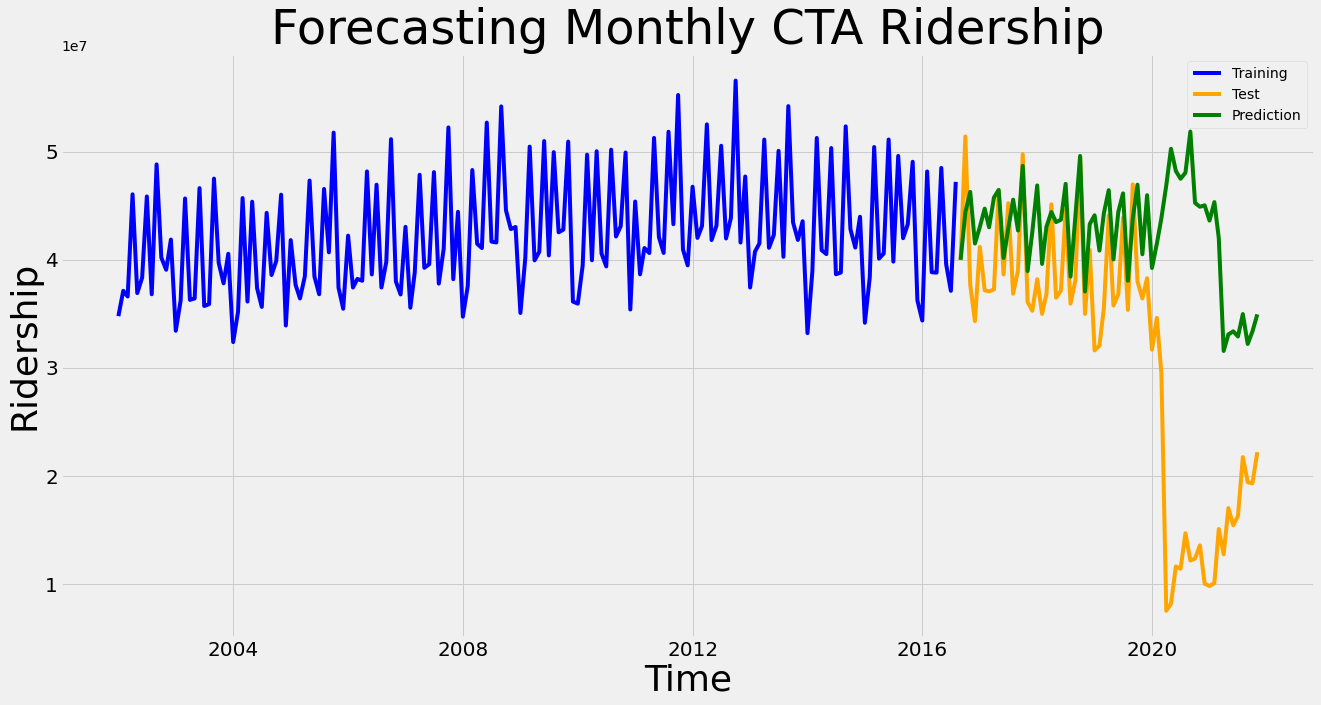

In [13]:
# Adapted from code by Hank Butler

plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue',label='Training',)

plt.plot(y_test.index, y_test.values, color = 'orange',label='Test')

plt.plot(lm_results.predict(X_test), color = 'green',label='Prediction')
# Set label.
plt.title(label = 'Forecasting Monthly CTA Ridership', fontsize=48)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.xlabel('Time', size=36)
plt.ylabel('Ridership', size=36)

plt.legend();

#plt.savefig('../capstone-data/imgs/Linear-annual-lag-monthly.png')

Does a pretty bad job as soon as we hit the pandemic, especially in comparison with shorter time series periods.

In [14]:
X_train,X_test,y_train,y_test = train_test_split(rides.drop(columns={'total_rides','lag_12'}),
                                                 rides['total_rides'],
                                                 test_size=.25,
                                                 shuffle=False)

In [15]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.head()

,const,lag_1,lag_2,lag_3,lag_4,lag_6,time
date,,,,,,,
2001-01-01,1.0,NaN,NaN,NaN,NaN,NaN,0
2001-02-01,1.0,36535438.0,NaN,NaN,NaN,NaN,1
2001-03-01,1.0,37427601.0,36535438.0,NaN,NaN,NaN,2
2001-04-01,1.0,38171646.0,37427601.0,36535438.0,NaN,NaN,3
2001-05-01,1.0,47096588.0,38171646.0,37427601.0,36535438.0,NaN,4


In [16]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]


lm = sm.OLS(y_train,X_train)

lm_results = lm.fit()

lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     11.57
Date:                Sun, 06 Feb 2022   Prob (F-statistic):           6.85e-11
Time:                        23:52:30   Log-Likelihood:                -3048.3
No. Observations:                 182   AIC:                             6111.
Df Residuals:                     175   BIC:                             6133.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.927e+07   7.29e+06      5.387      0.000    2.49e+07    5.37e+07
lag_1         -0.1718      0.073     -2.359      0.019      -0.315      -0.028
lag_2         -0.0341      0.074     -0.459      0.647      -0.181       0.113
lag_3          0.2200      0.074      2.966      0.003       0.074       0.366
lag_4         -0.1874      0.073     -2.558      0.011      -0.332      -0.043
lag_6          0.1883      0.074      2.561      0.011       0.043       0.333
time        2.437e+04   8213.672      2.967      0.003    8161.876    4.06e+04
==============================================================================
Omnibus:                        1.708   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.779
Skew:                           0.223   Prob(JB):                        0.411
Kurtosis:                       2.809   Cond. No.                     2.01e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
metrics.r2_score(y_test,lm_results.predict(X_test))

-1.4376056211536499

In [18]:
metrics.mean_squared_error(y_test,lm_results.predict(X_test),squared=False)

19463350.098282095

In [19]:
lm_results.aic

6110.610357549481

Initial and basic testing shows we are off by around 1,168,664 riders per day with an AIC of 25,224.

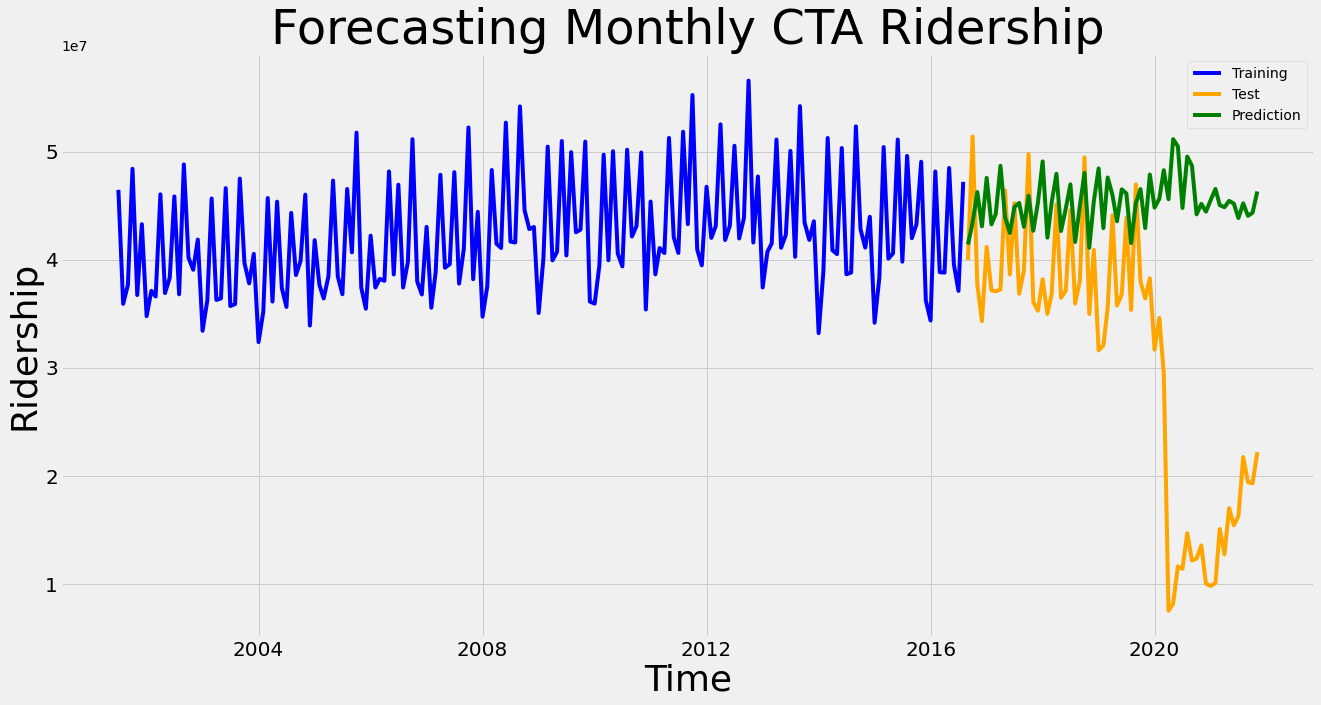

In [20]:
# Adapted from code by Hank Butler

plt.figure(figsize=(20,10))

plt.plot(y_train.index, y_train.values, color = 'blue',label='Training',)

plt.plot(y_test.index, y_test.values, color = 'orange',label='Test')

plt.plot(lm_results.predict(X_test), color = 'green',label='Prediction')
# Set label.
plt.title(label = 'Forecasting Monthly CTA Ridership', fontsize=48)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.xlabel('Time', size=36)
plt.ylabel('Ridership', size=36)

plt.legend();
#plt.savefig('../capstone-data/imgs/Linear-no-annual-monthly.png')

Removing the yearly lag seems to be even worse in this model.

## ARIMA

#### Finding '*d*'

In [21]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [22]:
rides['rides_first_diff'] = rides['total_rides'].diff(1)
rides['rides_second_diff'] = rides['total_rides'].diff(1).diff(1)

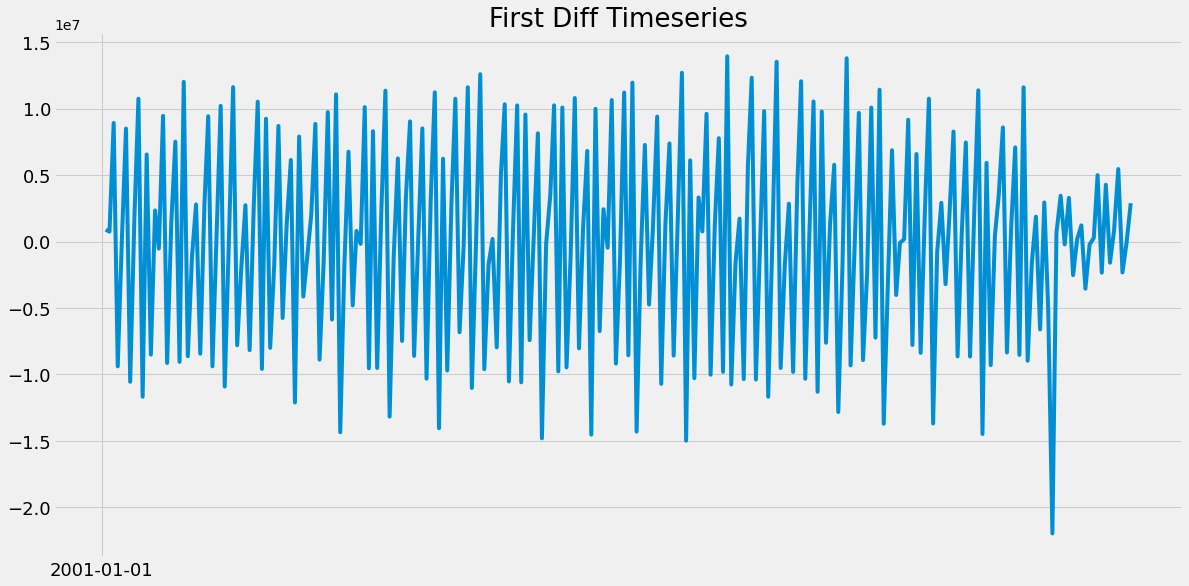

In [23]:
plot_series(rides,['rides_first_diff'], title = 'First Diff Timeseries', steps=1000)

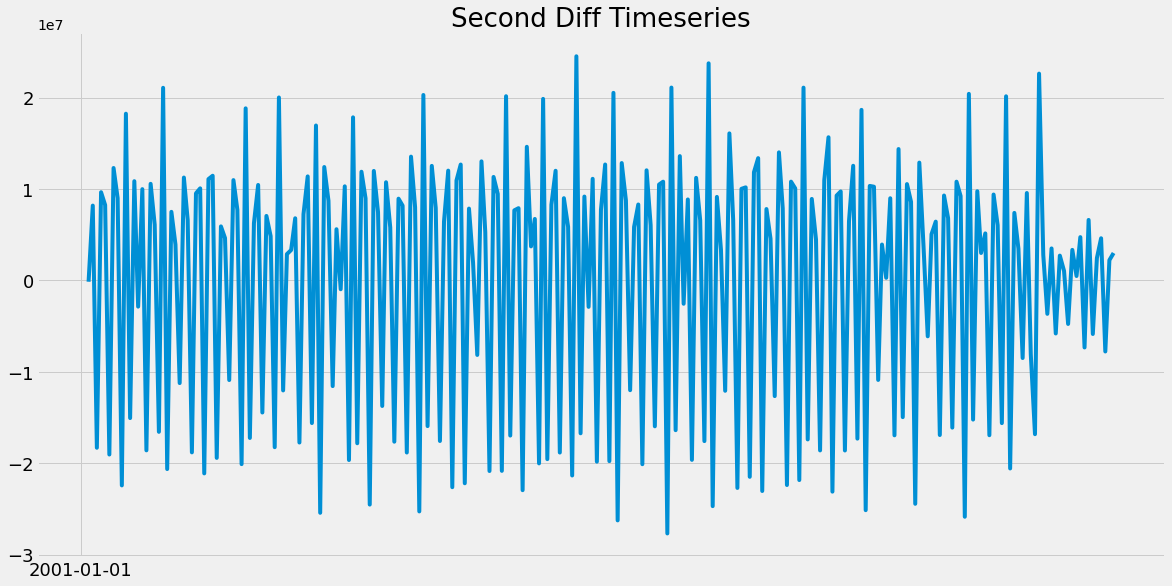

In [24]:
plot_series(rides,['rides_second_diff'], title = 'Second Diff Timeseries', steps=1000)

In [25]:
# Code written by Joseph Nelson
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2],index = ['Test Statsitic','p-value'])
    return dfoutput

In [26]:
print(f'Orig: \n{interpret_dftest(adfuller(rides["total_rides"]))}\n\nFirst Diff: \n{interpret_dftest(adfuller(rides["rides_first_diff"].dropna()))}')



Orig: 
Test Statsitic   -0.86114
p-value           0.80050
dtype: float64

First Diff: 
Test Statsitic   -4.150243
p-value           0.000799
dtype: float64


Since in the original data the p-value is not less than 0.05 we cannot reject Null Hypothesis; however, our first order difference is low enough to continue with '*d = 1*.'

#### Finding '*p*' & '*q*'

#### ARIMA

In [27]:
y_train, y_test = train_test_split(rides['rides_first_diff'].dropna(), test_size=.25,shuffle=False)

In [28]:
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

for p in range(20):
    for q in range(12):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order = (p, 1, q)) 
            
            model = arima.fit()

            if model.aic < best_aic:
                
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('Model Completed.')
print(f'Best ARIMA: ({best_p},1,{best_q}).')
print(f'AIC: {best_aic}.')



Model Completed.
Best ARIMA: (17,1,10).
AIC: 6139.962854958036.


In [29]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), 
             order = (17,1,10)) # Endog = Y variable 


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = arima.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])


In [30]:
print(f'AIC: {arima.aic}, RMSE: {metrics.mean_squared_error(y_test,preds,squared=False)}, STD: {rides["total_rides"].std()}')

AIC: 6139.962854958036, RMSE: 6515672.957051762, STD: 9197464.410217185


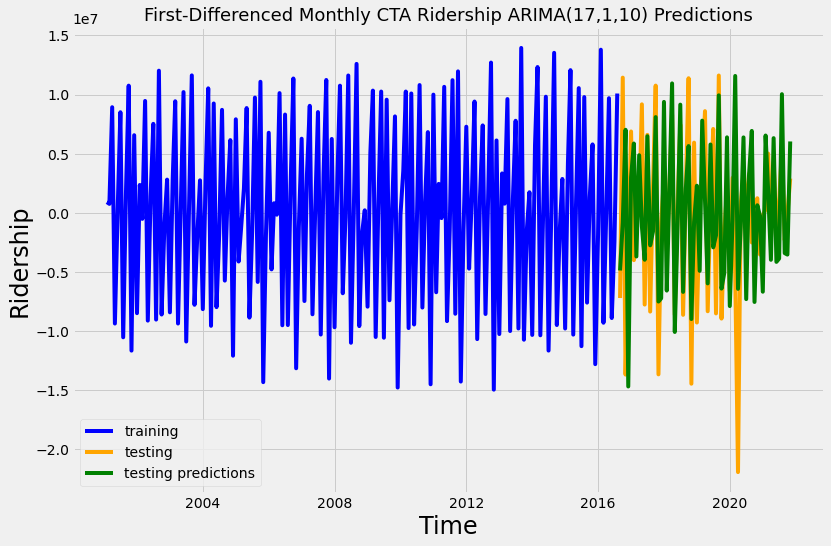

In [33]:
plt.figure(figsize=(12,8))
plt.plot(y_train, color = 'blue', label = 'training')
plt.plot(y_test, color = 'orange', label = 'testing')
plt.plot(preds, color = 'green', label ='testing predictions')
plt.title('First-Differenced Monthly CTA Ridership ARIMA(17,1,10) Predictions',fontsize=18)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership', size=24)
plt.legend();
#plt.savefig('../capstone-data/imgs/ARIMA(17,1,10).png')


The full ARIMA model seems decent but still struggles with the covid negative spike.

In [34]:
y_train.index.duplicated().sum()

0

#### Auto-ARIMA w/o Seasonality

In [35]:
y_train, y_test = train_test_split(rides['rides_first_diff'].dropna(), test_size=.25,shuffle=False)

In [36]:
arima_model = auto_arima(y_train,start_p=0,d=1,start_q=0,
                        max_p=20,max_d=1,max_q=20,seasonal=True,error_action='warn',
                         trace=2,supress_warnings='True',
                        stepwise=True,random_state=42,n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6664.390, Time=0.01 sec
First viable model found (6664.390)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6567.630, Time=0.01 sec
New best model found (6567.630 < 6664.390)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6479.985, Time=0.04 sec
New best model found (6479.985 < 6567.630)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6662.394, Time=0.01 sec
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6400.621, Time=0.04 sec
New best model found (6400.621 < 6479.985)
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6379.512, Time=0.09 sec
New best model found (6379.512 < 6400.621)
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6311.889, Time=0.08 sec
New best model found (6311.889 < 6379.512)
 ARIMA(2,1,1)(0,0,0)[0] i

In [37]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(3, 1, 5)   Log Likelihood               -3114.924
Date:                Sun, 06 Feb 2022   AIC                           6249.848
Time:                        23:59:42   BIC                           6282.106
Sample:                             0   HQIC                          6262.920
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.159e+04   1.73e+04     -0.668      0.504   -4.56e+04    2.24e+04
ar.L1         -2.1137      0.364     -5.800      0.000      -2.828      -1.399
ar.L2         -2.1059      0.421     -5.006      0.000      -2.930      -1.281
ar.L3         -0.9571      0.363     -2.635      0.008      -1.669      -0.245
ma.L1          0.1262      0.365      0.346      0.730      -0.589       0.842
ma.L2         -1.0726      0.296     -3.625      0.000      -1.653      -0.493
ma.L3         -1.0741      0.176     -6.113      0.000      -1.418      -0.730
ma.L4          0.1336      0.308      0.434      0.664      -0.469       0.737
ma.L5          0.9137      0.311      2.941      0.003       0.305       1.523
sigma2      3.053e+13   2.78e-07    1.1e+20      0.000    3.05e+13    3.05e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.56   Prob(JB):                         0.72
Heteroskedasticity (H):               1.15   Skew:                            -0.14
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.54e+36. Standard errors may be unstable.
"""

In [39]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(y_test.index)),index=y_test.index)
prediction.columns = ['pred_ridership']
prediction.head()

,pred_ridership
date,
2016-09-01,-1.048619e+07
2016-10-01,4.778189e+06
2016-11-01,3.463037e+06
2016-12-01,-9.447861e+06
2017-01-01,7.361081e+06


In [40]:
arima_model.aic()

6249.848184287603

In [41]:
metrics.mean_squared_error(y_test,prediction,squared=False)

6155633.01735594

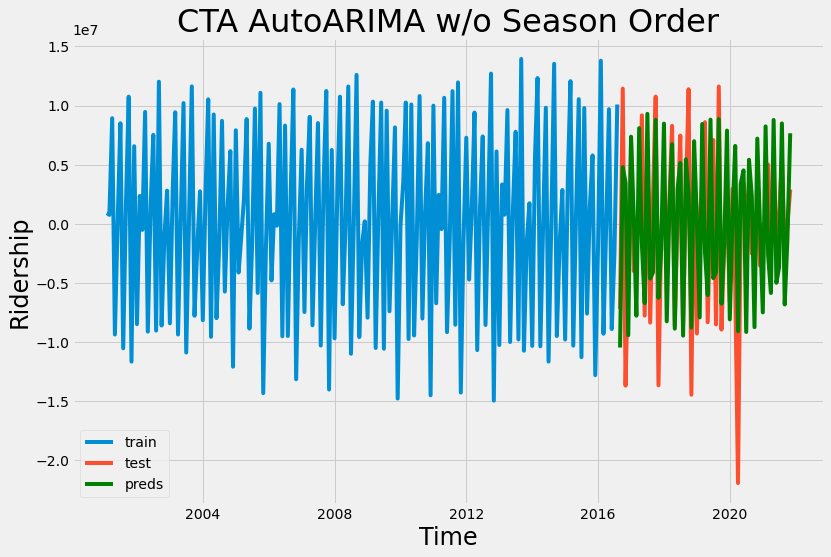

In [45]:
plt.figure(figsize=(12,8))
plt.plot(y_train,label='train')
plt.plot(y_test,label='test')
plt.plot(prediction,label = 'preds',color='green')
plt.title('CTA AutoARIMA w/o Season Order',size=32)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership',size=24)
plt.legend(loc = 'lower left');
#plt.savefig('../capstone-data/imgs/ARIMA(3,1,5)monthly.png')

### SARIMAX

In [49]:
model = SARIMAX(y_train.astype(float).dropna(), order=(8,1,5), seasonal_order=(6,1,4,12))
sari = model.fit()

In [50]:
preds_train = sari.predict(start = y_train.index[1], end = y_train.index[-1])
preds = sari.predict(start = y_test.index[0], end = y_test.index[-1])


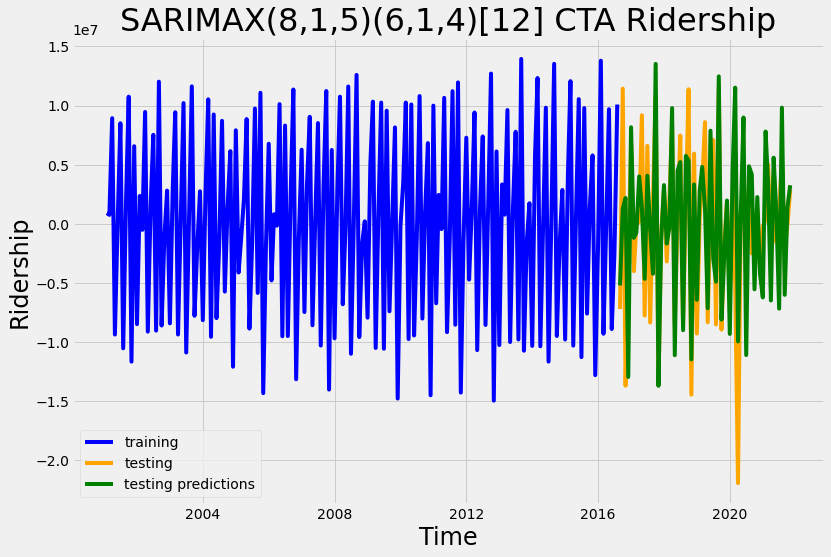

In [53]:
plt.figure(figsize=(12,8))
plt.plot(y_train, color = 'blue', label = 'training')

plt.plot(y_test, color = 'orange', label = 'testing')

plt.plot(preds, color = 'green', label ='testing predictions')
plt.title('SARIMAX(8,1,5)(6,1,4)[12] CTA Ridership', size=32)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership', size=24)

plt.legend();
#plt.savefig('../capstone-data/imgs/SARIMA(8,1,5)(6,1,4)[12].png')

In [54]:
print(f'SARIMAX: {sari.aic}')

SARIMAX: 5781.001095845009


In [55]:
metrics.mean_squared_error(y_test,preds,squared=False)

5461922.378432778

# VAR

In [56]:
mv = df[['total_rides','new_car_reg','20_yr','gas_price','tmin',
         'StringencyLegacyIndex','C6_Stay at home requirements','total_daily_doses','damage_indicator','ConfirmedDeaths']].copy()

In [57]:
mv

,total_rides,new_car_reg,20_yr,gas_price,tmin,StringencyLegacyIndex,C6_Stay at home requirements,total_daily_doses,damage_indicator,ConfirmedDeaths
date,,,,,,,,,,
2001-01-01,36535438.0,NaN,5.616571,1.52400,18.885714,0.000000,0.0,0.000000,0.000000,0.0
2001-02-01,37427601.0,NaN,5.631429,1.48225,21.392857,0.000000,0.0,0.000000,0.000000,0.0
2001-03-01,38171646.0,NaN,5.471786,1.38750,26.571429,0.000000,0.0,0.000000,0.000000,0.0
2001-04-01,47096588.0,NaN,5.754286,1.69380,42.714286,0.000000,0.0,0.000000,0.000000,0.0
2001-05-01,37710581.0,NaN,5.922500,1.98250,53.678571,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-07-01,16282441.0,7226.0,1.898929,3.38100,67.857143,50.042500,0.0,4053.964286,2.553681,721107.0
2021-08-01,21739374.0,21676.0,1.828571,3.38600,69.628571,39.693429,0.0,4653.400000,2.558188,911728.0
2021-09-01,19418701.0,4021.0,1.857500,3.37650,62.428571,34.520000,0.0,4376.928571,2.565953,750985.0


In [62]:
print(f'total_rides 1 diff: \n{interpret_dftest(adfuller(mv["total_rides"].diff(1).dropna()))}')
print()

print(f'20_yr 1 diff: \n{interpret_dftest(adfuller(mv["20_yr"].diff(1).dropna()))}')
print()

print(f'new car 1 diff: \n{interpret_dftest(adfuller(mv["new_car_reg"].diff(1).dropna()))}')
print()

print(f'gas_price 1 diff: \n{interpret_dftest(adfuller(mv["gas_price"].diff(1).dropna()))}')
print()

print(f'tmin NO diff: \n{interpret_dftest(adfuller(mv["tmin"]))}')
print()

print(f'StringencyLegacyIndex 1 diff: \n{interpret_dftest(adfuller(mv["StringencyLegacyIndex"].diff(1).dropna()))}')
print()

print(f'C6_Stay at home requirements NO diff: \n{interpret_dftest(adfuller(mv["C6_Stay at home requirements"].dropna()))}')
print()

print(f'total_daily_doses 1 NO diff: \n{interpret_dftest(adfuller(mv["total_daily_doses"].dropna()))}')
print()

print(f'damage_indicator 1 diff: \n{interpret_dftest(adfuller(mv["damage_indicator"].diff(1).dropna()))}')
print()

print(f'ConfirmedDeaths 2 diff: \n{interpret_dftest(adfuller(mv["ConfirmedDeaths"].diff(1).diff(1).dropna()))}')

total_rides 1 diff: 
Test Statsitic   -4.150243
p-value           0.000799
dtype: float64

20_yr 1 diff: 
Test Statsitic   -1.128334e+01
p-value           1.438030e-20
dtype: float64

new car 1 diff: 
Test Statsitic   -3.531093
p-value           0.007224
dtype: float64

gas_price 1 diff: 
Test Statsitic   -8.860266e+00
p-value           1.489448e-14
dtype: float64

tmin NO diff: 
Test Statsitic   -3.596029
p-value           0.005837
dtype: float64

StringencyLegacyIndex 1 diff: 
Test Statsitic   -3.690036
p-value           0.004256
dtype: float64

C6_Stay at home requirements NO diff: 
Test Statsitic   -3.932875
p-value           0.001806
dtype: float64

total_daily_doses 1 NO diff: 
Test Statsitic   -47.403222
p-value            0.000000
dtype: float64

damage_indicator 1 diff: 
Test Statsitic   -1.163040e+01
p-value           2.269882e-21
dtype: float64

ConfirmedDeaths 2 diff: 
Test Statsitic   -7.058793e+00
p-value           5.289505e-10
dtype: float64


Making sure data is stationary with a threshold of <.05 to allow of rrejection of the null hypothesis.

In [64]:
mv['total_rides_diff'] = mv['total_rides'].diff(1)
mv['20_yr_diff'] = mv['20_yr'].diff(1)
mv['gas_price_diff'] = mv['gas_price'].diff(1)
mv['new_car_diff'] = mv["new_car_reg"].diff(1)
mv['Stringency_diff'] = mv['StringencyLegacyIndex'].diff(1)
mv['damage_indicator_diff'] = mv['damage_indicator'].diff(1)
mv['ConfirmedDeaths_diff'] = mv['ConfirmedDeaths'].diff(1).diff(1)

In [118]:
mv2 = mv[['total_rides_diff','20_yr_diff','new_car_diff','tmin','gas_price_diff']]

In [119]:
train,test = train_test_split(mv2.dropna(),test_size=.25,shuffle=False,random_state=42)

In [120]:
train.head()

,total_rides_diff,20_yr_diff,new_car_diff,tmin,gas_price_diff
date,,,,,
2006-02-01,-4801182.0,0.095286,-1364.0,21.535714,-0.07365
2006-03-01,796330.0,0.148929,1023.5,30.464286,0.22150
2006-04-01,-171753.0,0.298929,0.0,44.500000,0.30700
2006-05-01,10118900.0,0.160857,432.0,49.771429,0.13295
2006-06-01,-9532897.0,-0.059071,2902.0,61.392857,0.06080


In [121]:
model = VAR(train)

In [122]:
ts_model = model.fit(maxlags = 5, ic = 'bic')

In [123]:
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Feb, 2022
Time:                     00:17:12
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    44.4703
Nobs:                     140.000    HQIC:                   43.7843
Log likelihood:          -3970.28    FPE:                6.48651e+18
AIC:                      43.3146    Det(Omega_mle):     4.44392e+18
--------------------------------------------------------------------
Results for equation total_rides_diff
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                 -470352.212301   1325693.309089           -0.355           0.723
L1.total_rides_diff        -0.981014         0.066753          -14.696           0.000
L1.20_yr_diff        -166

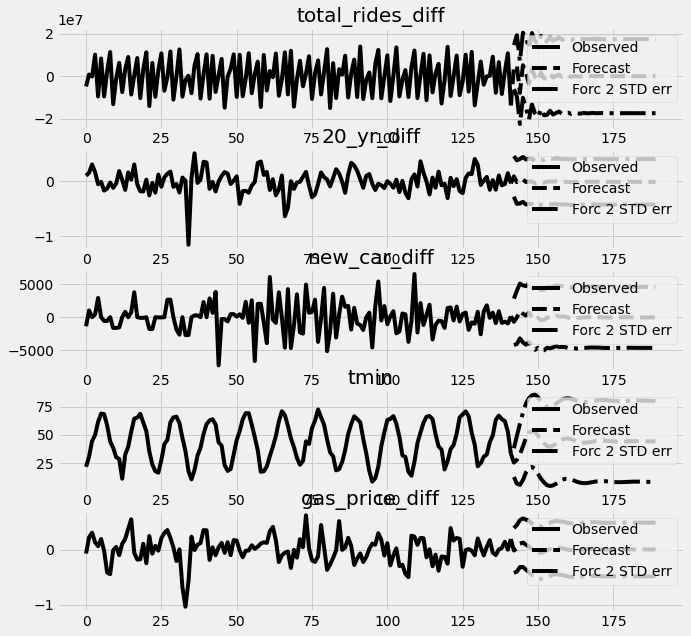

In [124]:
ts_model.plot_forecast(len(test));


In [127]:
ts_model.aic

43.31463312194066

In [128]:
# Let's use MSE to evaluate our models.

# Save our forecast as forecast.
forecast = ts_model.forecast(train.values, len(test))

# Instantiate MSE values at 0.
mse_riders = 0
mse_20_yr = 0
mse_damage = 0
mse_tmin = 0


# Loop through each forecasted time point.
for time in range(len(test)):
    
    # Calculate (expected - observed) ** 2 and add to MSE.
    mse_riders += (forecast[time][0] - test.values[time][0]) ** 2
    mse_20_yr += (forecast[time][1] - test.values[time][1]) ** 2
    mse_damage += (forecast[time][2] - test.values[time][2]) ** 2
    mse_tmin += (forecast[time][3] - test.values[time][3]) ** 2

# Divide SSE to get MSE.
mse_riders /= len(test)
mse_20_yr /= len(test)
mse_damage /= len(test)
mse_tmin /= len(test)

# Generate output.    
print(f'The test RMSE on the Ridership data is: {round(mse_riders**.5, 4)}')
print(f'The test RMSE on the 20_yr data is: {round(mse_20_yr**.5, 4)}')
print(f'The test RMSE on the damage data is: {round(mse_damage**.5, 4)}')
print(f'The test RMSE on the tmin data is: {round(mse_tmin**.5, 4)}')

The test RMSE on the Ridership data is: 6278740.813
The test RMSE on the 20_yr data is: 0.1695
The test RMSE on the damage data is: 3540.6267
The test RMSE on the tmin data is: 15.9085


# Prophet

In [532]:
#df = pd.read_csv('../capstone-data/daily-merged.csv')
df = pd.read_csv('../capstone-data/monthly-merged.csv')

In [533]:
df.tail()

,date,bus,rail_boardings,total_rides,prcp,tmax,tmin,gas_open,gas_close,gas_volume,3_mo,6_mo,1_yr,2_yr,3_yr,5_yr,7_yr,10_yr,20_yr,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyLegacyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,total_daily_doses,total_daily_cum,first_dose_daily,first_dose_cum,first_dose_percent_pop,vax_series_completed_daily,vax_series_cum,vax_series_percent,crash_occurrences,damage_indicator,gas_price,new_light_truck_reg,new_car_reg,new_total_reg
247,2021-08-01,12359912.0,9379462.0,21739374.0,0.122571,86.142857,69.628571,2.244837,2.240863,61321.828571,0.055429,0.053714,0.073714,0.215143,0.411714,0.764286,1.055429,1.279429,1.828571,0.0,0.0,0.542857,0.0,0.0,0.0,1.0,3.000000,1.0,2.0,2.0,3.0,1.000000,2.0,5.0,1.0,51067096.0,911728.0,28.018286,39.693429,43.779714,41.1040,62.5,4653.400000,103471886.0,2558.200000,55656932.0,0.590343,2028.514286,50929673.0,0.540171,11399.0,2.558188,3.38600,16901.0,21676.0,21676.0
248,2021-09-01,11100267.0,8318434.0,19418701.0,0.035000,81.250000,62.428571,2.153382,2.159039,59610.785714,0.042500,0.052500,0.075714,0.232143,0.460000,0.842143,1.139643,1.354643,1.857500,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,3.000000,1.0,2.0,2.0,3.0,1.678571,2.0,5.0,1.0,44055391.0,750985.0,25.000000,34.520000,44.827143,42.3025,62.5,4376.928571,86859432.0,1917.071429,46524477.0,0.616821,1980.214286,42600157.0,0.564679,9228.0,2.565953,3.37650,14109.0,4021.0,18130.0
249,2021-10-01,11029821.0,8281187.0,19311008.0,0.241429,71.214286,56.607143,2.373679,2.397532,62762.428571,0.049286,0.060714,0.104286,0.359643,0.632143,1.075714,1.385714,1.580714,2.042857,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,3.000000,1.0,1.0,2.0,3.0,1.821429,2.0,5.0,2.0,46342961.0,776072.0,25.000000,34.520000,44.232857,45.1925,37.5,6709.285714,91236650.0,1577.642857,47877629.0,0.634643,1633.892857,44012030.0,0.583500,9026.0,2.567908,3.50025,17447.0,5041.0,22488.0
250,2021-11-01,12765410.0,9431229.0,22196639.0,0.038571,49.828571,34.571429,2.331880,2.302194,57937.228571,0.052571,0.072286,0.171143,0.502286,0.808571,1.196571,1.442857,1.555714,1.968857,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.914286,1.0,1.0,2.0,3.0,2.000000,2.0,5.0,2.0,60801425.0,997059.0,21.981714,30.644000,43.096286,43.8920,37.5,11522.714286,124431161.0,3099.285714,62439221.0,0.662171,1739.828571,56851449.0,0.602943,10729.0,2.592379,3.55560,13562.0,3328.0,16890.0
251,2021-12-01,450230.0,302349.0,752579.0,0.000000,53.000000,33.000000,2.103600,1.980100,83219.000000,0.050000,0.100000,0.240000,0.520000,0.810000,1.140000,1.360000,1.430000,1.850000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,3.000000,1.0,1.0,2.0,3.0,2.000000,2.0,5.0,2.0,1809875.0,28847.0,25.000000,34.520000,44.790000,45.8300,37.5,16112.000000,3768035.0,2891.000000,1841295.0,0.683000,4136.000000,1657952.0,0.615000,274.0,2.463504,3.48100,20876.0,4820.0,25696.0


In [534]:
df['date'] = pd.to_datetime(df['date'])
#df = df.drop(df.tail(1).index)
#df = df.drop(df.head(1).index)

In [535]:
df.rename(columns={'date':'ds','total_rides':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df = df[['ds','y']]


In [536]:
y_train, y_test = train_test_split(df,test_size=.05, shuffle=False,random_state=42)

In [537]:
m = Prophet()
m.fit(y_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [538]:
future.tail()

,ds
247,2021-08-01
248,2021-09-01
249,2021-10-01
250,2021-11-01
251,2021-12-01


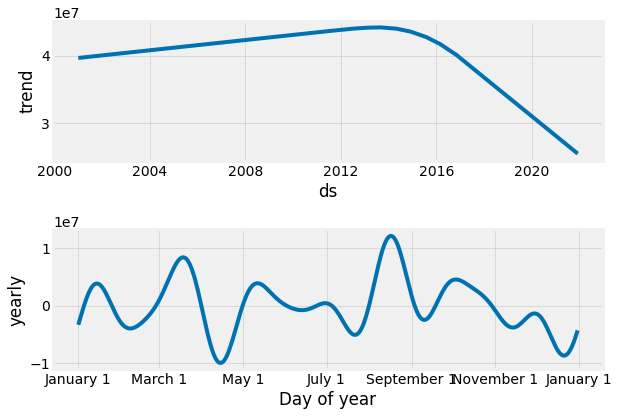

In [539]:
future = m.make_future_dataframe(periods=len(y_test),freq='MS')
forecast = m.predict(future)
fig = m.plot_components(forecast)
#plt.savefig('../capstone-data/imgs/Prophetweeklycomp.png')

In [540]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
247,2021-08-01,2.647888e+07,1.904382e+07,3.385836e+07
248,2021-09-01,2.785298e+07,2.062665e+07,3.570834e+07
249,2021-10-01,3.035655e+07,2.327261e+07,3.823260e+07
250,2021-11-01,2.480915e+07,1.785159e+07,3.230887e+07
251,2021-12-01,2.402875e+07,1.686619e+07,3.171699e+07


In [541]:
y_test.head()

,ds,y
239,2020-12-01,10026535.0
240,2021-01-01,9815638.0
241,2021-02-01,10084309.0
242,2021-03-01,15084587.0
243,2021-04-01,12746600.0


In [542]:
y_test.tail()

,ds,y
247,2021-08-01,21739374.0
248,2021-09-01,19418701.0
249,2021-10-01,19311008.0
250,2021-11-01,22196639.0
251,2021-12-01,752579.0


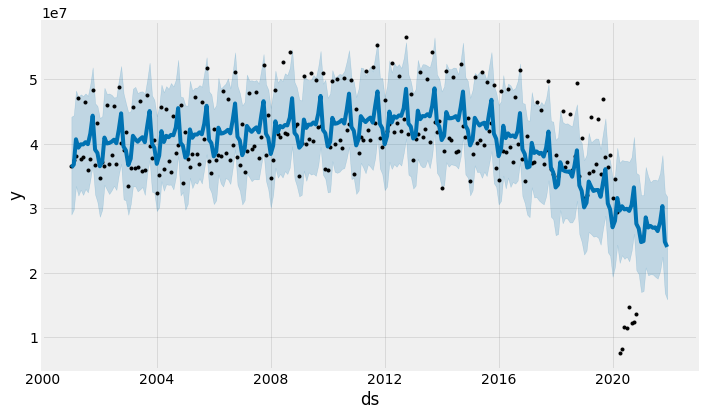

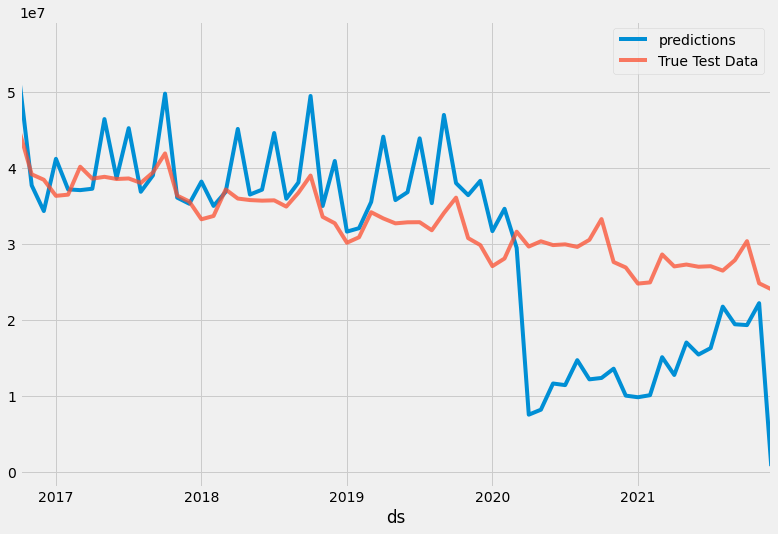

In [237]:
m.plot(forecast)
ax1=df.plot(x='ds',y='y',legend=True,label='predictions',figsize=(12,8),)
#plt.savefig('../capstone-data/imgs/ProphetpredsMonthly1.png')
forecast.plot(x='ds',y='yhat',legend=True,label='True Test Data',ax=ax1,
              xlim=('2016-10-01','2021-12-01'),alpha=.75);
#plt.savefig('../capstone-data/imgs/ProphetpredsMonthl2.png')

In [238]:
fig =plot_plotly(m, forecast)

#fig.write_html("../capstone-data/imgs/interactive3.html")

In [239]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,3.965241e+07,2.905283e+07,4.420476e+07,3.965241e+07,3.965241e+07,-3.307434e+06,-3.307434e+06,-3.307434e+06,-3.307434e+06,-3.307434e+06,-3.307434e+06,0.0,0.0,0.0,3.634498e+07
1,2001-02-01,3.968486e+07,2.982971e+07,4.443777e+07,3.968486e+07,3.968486e+07,-2.908545e+06,-2.908545e+06,-2.908545e+06,-2.908545e+06,-2.908545e+06,-2.908545e+06,0.0,0.0,0.0,3.677631e+07
2,2001-03-01,3.971417e+07,3.346124e+07,4.825598e+07,3.971417e+07,3.971417e+07,9.926478e+05,9.926478e+05,9.926478e+05,9.926478e+05,9.926478e+05,9.926478e+05,0.0,0.0,0.0,4.070681e+07
3,2001-04-01,3.974662e+07,3.198831e+07,4.723622e+07,3.974662e+07,3.974662e+07,-3.379328e+05,-3.379328e+05,-3.379328e+05,-3.379328e+05,-3.379328e+05,-3.379328e+05,0.0,0.0,0.0,3.940868e+07
4,2001-05-01,3.977802e+07,3.289321e+07,4.768005e+07,3.977802e+07,3.977802e+07,1.462744e+05,1.462744e+05,1.462744e+05,1.462744e+05,1.462744e+05,1.462744e+05,0.0,0.0,0.0,3.992429e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2021-08-01,2.640638e+07,1.911685e+07,3.431860e+07,2.635516e+07,2.646470e+07,7.249677e+04,7.249677e+04,7.249677e+04,7.249677e+04,7.249677e+04,7.249677e+04,0.0,0.0,0.0,2.647888e+07
248,2021-09-01,2.616137e+07,2.025732e+07,3.551570e+07,2.609641e+07,2.623304e+07,1.691615e+06,1.691615e+06,1.691615e+06,1.691615e+06,1.691615e+06,1.691615e+06,0.0,0.0,0.0,2.785298e+07
249,2021-10-01,2.592425e+07,2.251295e+07,3.824279e+07,2.584550e+07,2.601269e+07,4.432296e+06,4.432296e+06,4.432296e+06,4.432296e+06,4.432296e+06,4.432296e+06,0.0,0.0,0.0,3.035655e+07
250,2021-11-01,2.567924e+07,1.688819e+07,3.241203e+07,2.558545e+07,2.578402e+07,-8.700913e+05,-8.700913e+05,-8.700913e+05,-8.700913e+05,-8.700913e+05,-8.700913e+05,0.0,0.0,0.0,2.480915e+07


In [240]:
forecast['ds']=pd.to_datetime(forecast['ds'])
forecast.set_index('ds',inplace=True)

y_train['ds']=pd.to_datetime(y_train['ds'])
y_train.set_index('ds',inplace=True)

y_test['ds']=pd.to_datetime(y_test['ds'])
y_test.set_index('ds',inplace=True)

In [241]:
y_test.head()

,y
ds,
2020-12-01,10026535.0
2021-01-01,9815638.0
2021-02-01,10084309.0
2021-03-01,15084587.0
2021-04-01,12746600.0


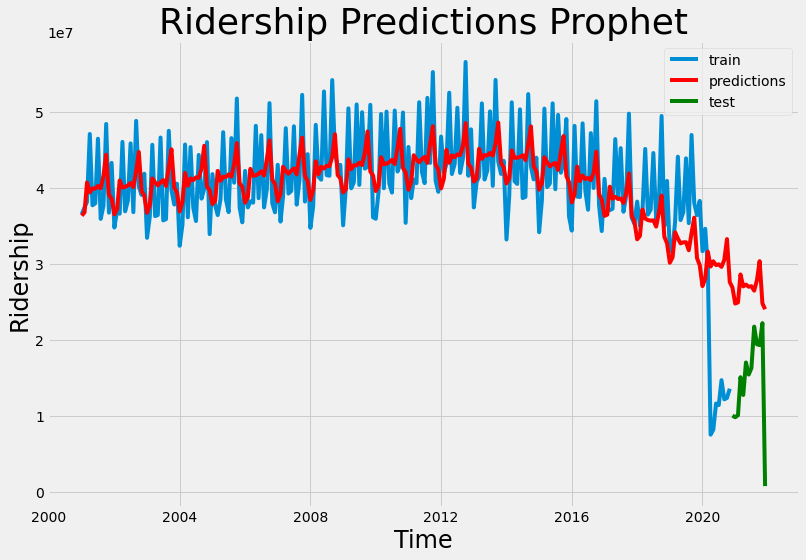

In [242]:
plt.figure(figsize=(12,8))
plt.plot(y_train['y'], label = 'train' )
plt.plot(forecast[['yhat']].tail(len(y_test)+1000),color='r', label ='predictions')
plt.plot(y_test['y'], label='test',color='green')
plt.title('Ridership Predictions Prophet', size=36)
plt.xlabel('Time',size=24)
plt.ylabel('Ridership',size=24)
plt.legend();
#plt.savefig('../capstone-data/imgs/Prophetpredsmonthly3.png')

In [243]:
forecast[['yhat']]

,yhat
ds,
2001-01-01,3.634498e+07
2001-02-01,3.677631e+07
2001-03-01,4.070681e+07
2001-04-01,3.940868e+07
2001-05-01,3.992429e+07
...,...
2021-08-01,2.647888e+07
2021-09-01,2.785298e+07
2021-10-01,3.035655e+07


In [543]:
pro_preds = forecast[['yhat']].tail(len(y_test))
metrics.mean_squared_error(y_test[['y']], pro_preds,squared=False)

13110986.038360413

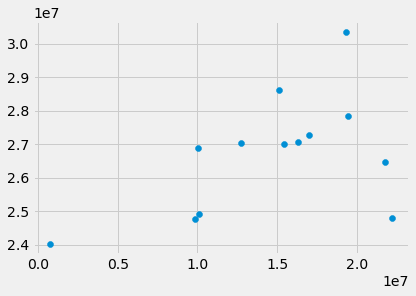

In [547]:
plt.scatter(y_test['y'],pro_preds['yhat'])

In [245]:
initial= '5000 days'
period= '365 days'
horizon = 365/2
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,horizon)
# Performance Metrics of fb_cv
performance_metrics(fb_cv,rolling_window=.01)

INFO:fbprophet:Making 72 forecasts with cutoffs between 2002-08-06 18:00:00 and 2020-05-02 12:00:00


  0%|          | 0/72 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,24 days 18:00:00,7.010569e+13,8.372914e+06,6.694008e+06,0.159850,0.108774,0.5000
1,25 days 00:00:00,4.257109e+13,6.524653e+06,4.828760e+06,0.115406,0.087780,0.5000
2,25 days 06:00:00,5.833104e+13,7.637476e+06,6.522232e+06,0.140146,0.168514,0.2500
3,25 days 12:00:00,1.907316e+13,4.367282e+06,3.645250e+06,0.095177,0.096757,0.7500
4,25 days 18:00:00,3.961648e+13,6.294162e+06,6.171818e+06,0.129359,0.127340,0.2500
5,26 days 00:00:00,1.774494e+13,4.212475e+06,3.823488e+06,0.106867,0.111294,0.5000
6,26 days 06:00:00,2.408701e+13,4.907852e+06,4.340543e+06,0.108579,0.127747,0.2500
7,26 days 12:00:00,7.099009e+13,8.425562e+06,7.126241e+06,0.145430,0.127267,0.5000
8,26 days 18:00:00,1.965915e+13,4.433864e+06,4.314106e+06,0.092297,0.097536,1.0000
9,27 days 00:00:00,3.432951e+13,5.859139e+06,5.765582e+06,0.151282,0.153728,0.2500


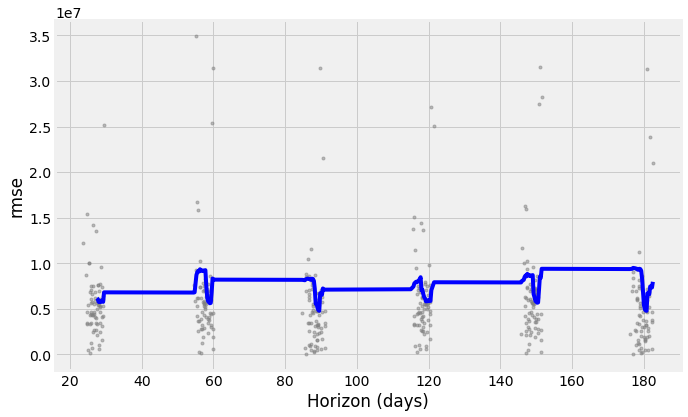

In [246]:
plot_cross_validation_metric(fb_cv,'rmse');

# Linear Regression

In [259]:
#df = pd.read_csv('../capstone-data/daily-merged.csv')
df = pd.read_csv('../capstone-data/monthly-merged.csv')

In [260]:
df.head()

,date,bus,rail_boardings,total_rides,prcp,tmax,tmin,gas_open,gas_close,gas_volume,3_mo,6_mo,1_yr,2_yr,3_yr,5_yr,7_yr,10_yr,20_yr,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,E2_Debt/contract relief,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyLegacyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,total_daily_doses,total_daily_cum,first_dose_daily,first_dose_cum,first_dose_percent_pop,vax_series_completed_daily,vax_series_cum,vax_series_percent,crash_occurrences,damage_indicator,gas_price,new_light_truck_reg,new_car_reg,new_total_reg
0,2001-01-01,23041470.0,13493968.0,36535438.0,0.031429,30.828571,18.885714,0.844743,0.850791,15564.657143,5.403429,5.238571,4.881714,4.788857,4.788286,4.838857,5.102857,5.113143,5.616571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.52400,NaN,NaN,NaN
1,2001-02-01,23759284.0,13668317.0,37427601.0,0.120357,36.285714,21.392857,0.868661,0.872911,16613.464286,5.018571,4.902857,4.697857,4.675000,4.726071,4.896786,5.111429,5.120000,5.631429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.48225,NaN,NaN,NaN
2,2001-03-01,24168043.0,14003603.0,38171646.0,0.054643,41.892857,26.571429,0.882089,0.883479,16562.321429,4.604286,4.510357,4.333929,4.361429,4.436786,4.643214,4.880000,4.872857,5.471786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38750,NaN,NaN,NaN
3,2001-04-01,29703959.0,17392629.0,47096588.0,0.097429,63.028571,42.714286,1.016229,1.020600,22347.628571,4.010857,4.006571,4.010286,4.242857,4.424000,4.753714,5.020000,5.117429,5.754286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.69380,NaN,NaN,NaN
4,2001-05-01,23772416.0,13938165.0,37710581.0,0.131071,72.714286,53.678571,1.068571,1.070586,21264.178571,3.703214,3.749643,3.795357,4.267857,4.513571,4.931429,5.240000,5.390000,5.922500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.98250,NaN,NaN,NaN


In [261]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.sort_index(inplace=True)
df= df.asfreq('MS').dropna()
# df = df.drop(df.tail(1).index)
# df = df.drop(df.head(1).index)

In [262]:
df['total_rides'].mean(), df['total_rides'].std()

(38942478.4375, 10557844.73254144)

In [263]:
df.columns

Index(['bus', 'rail_boardings', 'total_rides', 'prcp', 'tmax', 'tmin',
       'gas_open', 'gas_close', 'gas_volume', '3_mo', '6_mo', '1_yr', '2_yr',
       '3_yr', '5_yr', '7_yr', '10_yr', '20_yr', 'C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people',
       'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyLegacyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'total_daily_doses',
       'total_daily_cum', 'first_dose_daily', 'first_dose_cum',
       'first_dose_percent_pop', 'vax_

In [512]:
X=df.drop(columns={'bus', 'rail_boardings', 'total_rides', 'prcp', 'tmax',
       'gas_open',  'gas_volume', '3_mo', '6_mo', '1_yr', '2_yr',
       '3_yr', '5_yr', '7_yr',
        'H8_Protection of elderly people',
       'ConfirmedCases',  'StringencyIndex',
        'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 
       'total_daily_cum', 'first_dose_daily', 'first_dose_cum',
       'first_dose_percent_pop', 'vax_series_completed_daily',
       'vax_series_cum',  'new_light_truck_reg', 'new_car_reg',})
y =df['total_rides']

In [513]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=42,)#shuffle=False)

In [494]:
lr = LinearRegression()

In [495]:
lr.fit(X_train,y_train)

LinearRegression()

In [499]:
lr.score(X_train,y_train),lr.score(X_test,y_test)

(0.8480482072069044, 0.6789922340034052)

In [529]:
preds=lr.predict(X_test)

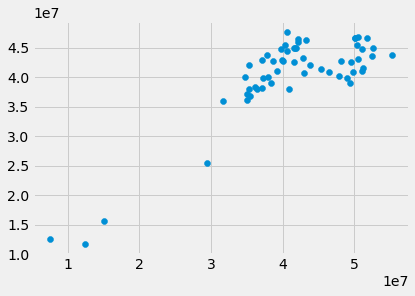

In [530]:
plt.scatter(y_test,preds)

In [501]:
metrics.mean_squared_error(y_test,preds,squared=False)

5239220.3997038165

In [286]:
df.columns

Index(['bus', 'rail_boardings', 'total_rides', 'prcp', 'tmax', 'tmin',
       'gas_open', 'gas_close', 'gas_volume', '3_mo', '6_mo', '1_yr', '2_yr',
       '3_yr', '5_yr', '7_yr', '10_yr', '20_yr', 'C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people',
       'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyLegacyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'total_daily_doses',
       'total_daily_cum', 'first_dose_daily', 'first_dose_cum',
       'first_dose_percent_pop', 'vax_

# RandomForest

In [503]:
rf = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators':range(100,1000,100),
    'max_depth': range(4,11),
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': [1],
}

rf_grid = GridSearchCV(rf,rf_params,cv=5,verbose=1,n_jobs=-1)

In [504]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(4, 11), 'min_samples_leaf': [1],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': range(100, 1000, 100)},
             verbose=1)

In [505]:
rf_grid.best_params_

{'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [507]:
rf_grid.score(X_train,y_train),rf_grid.score(X_test,y_test)


(0.8999606427482632, 0.6316305683756726)

In [526]:
preds = rf_grid.predict(X_test)

In [527]:
metrics.mean_squared_error(y_test,preds,squared=False)

5612426.813323667

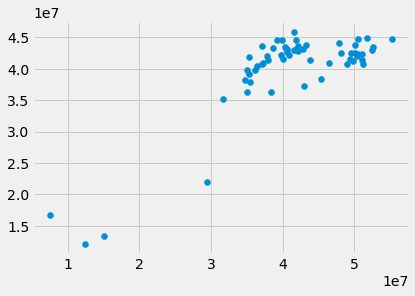

In [528]:
plt.scatter(y_test,preds)

# XGBoost

In [514]:
boost = xgb.XGBRegressor(booster = 'gbtree', random_seed=42)

xg_params= {
    'eta': [.1,.2,.4,.5,.8,1],
    'gamma': [0,1,2],
    'max_depth': range(1,11,1),
    'subsample':[.5,1]
}

boost_grid = GridSearchCV(boost,xg_params,n_jobs=-1,cv=5,verbose=1)

In [515]:
boost_grid.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[01:19:10] WARNING: ../src/learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_seed=42, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
          

In [516]:
boost_grid.best_params_

{'eta': 0.1, 'gamma': 0, 'max_depth': 1, 'subsample': 1}

In [517]:
boost_grid.score(X_train,y_train),boost_grid.score(X_test,y_test)

(0.8730555405998878, 0.6371435340364087)

In [524]:
preds = boost_grid.predict(X_test)
metrics.mean_squared_error(y_test,preds,squared=False)

5570271.095191039

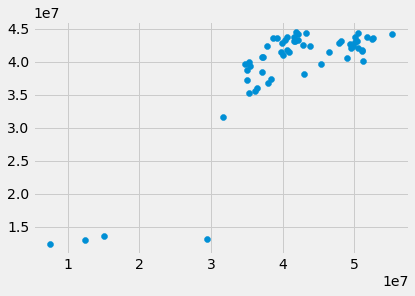

In [525]:
plt.scatter(y_test,preds)

In [519]:
boost = xgb.XGBRegressor(booster = 'gblinear', random_seed=42)

boost.fit(X_train,y_train)

[01:26:08] WARNING: ../src/learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=16, num_parallel_tree=None,
             predictor=None, random_seed=42, random_state=0, reg_alpha=0,
             reg_lambda=0, scale_pos_weight=1, subsample=None, tree_method=None,
             validate_parameters=1, verbosity=None)

In [520]:
boost.score(X_train,y_train),boost.score(X_test,y_test)

(0.8294199074226202, 0.6365379324126081)

In [521]:
preds= boost.predict(X_test)
metrics.mean_squared_error(y_test,preds,squared=False)

5574917.503877087

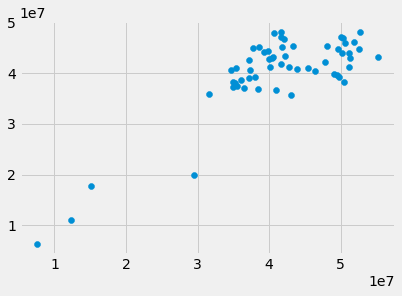

In [523]:
plt.scatter(y_test,preds)

| Model                     | RMSE          | Other          |
|---------------------------|---------------|----------------|
| LinearTime w/ Annual      | 17,196,311.05 | AIC: 5,879.04  |
| LinearTime w/o Annual     | 19,463,350.10 | AIC: 6,110.61  |
| ARIMA(17,1,10)            | 6,515,672.95  | AIC: 6,139.96  |
| Auto-ARIMA(3,1,5)         | 6,155,633.02  | AIC: 6,249.84  |
| SARIMAX(8,1,5)(6,1,4)[12] | 5,461,922.37  | AIC: 5,781.00  |
| VAR                       | 6,278,740.81  | AIC/BIC: ~44   |
| Prophet                   | 13,110,986.04 | MAPE: 0.10     |
| LinearRegression          | 5,239,220.40  | R2:0.85, 0.68  |
| RandomForest              | 5,612,426.81  | R2: 0.89, 0.63 |
| XGBoostRegressor(tree)    | 5,570,271.10  | R2: 0.87, 0.64 |
| XGBoostRegressor(linear)  | 5,574,917.50  | R2: 0.83, 0.63 |
|                           |               |                |
|                           |               |                |
|                           |               |                |